In [1]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import namedtuple

searching for scad in: /Users/robbie/anaconda3/envs/cv/bin:/Users/robbie/anaconda3/envs/cv/bin:/Users/robbie/anaconda3/condabin:/Users/robbie/anaconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public:/Library/TeX/texbin:/opt/X11/bin:/Applications/OpenSCAD.app/Contents/MacOS


## Section 2: Morphable Model

In [2]:
# Load Data
bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32)
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32)
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)
E_id = pcaBasis_id[:,:30].reshape((-1,3,30))
E_exp = pcaBasis_exp[:,:20].reshape((-1,3,20))
sigma_id = np.sqrt(pcaVariance_id[:30])
sigma_exp = np.sqrt(pcaVariance_exp[:20])

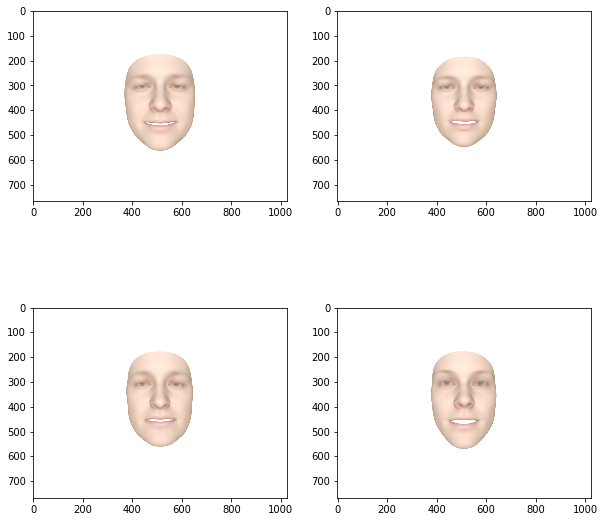

In [3]:
# Generate point clouds using uniform sample
os.makedirs('results/',exist_ok=True)
fig1 = plt.figure(figsize = (10,10))
for i in range(4):
    alpha = np.random.uniform(-1,1,30)
    delta = np.random.uniform(-1,1,20)
    G = mu_id + E_id @ (alpha*sigma_id)  + mu_exp + E_exp @ (delta*sigma_exp)
    mesh = Mesh(G, mean_tex, triangles)
    filepath = 'results/point_cloud_sample{}.png'.format(i+1)
    mesh_to_png(filepath, mesh) 
    image = mpimg.imread(filepath)
    subplot = fig1.add_subplot(2,2,i+1)
    subplot.imshow(image)
plt.show()

## Section 3: Pinhole Camera Model

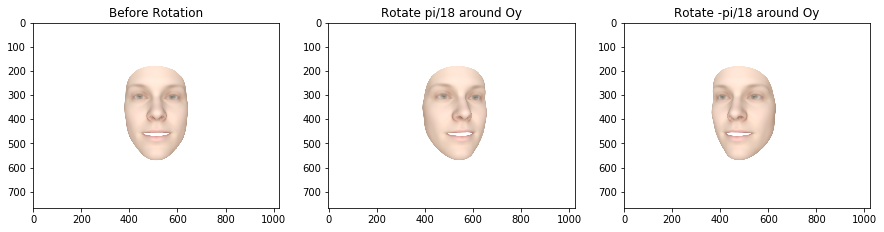

In [4]:
# Rotate around Oy.
fig2 = plt.figure(figsize = (15,10))
subplot = fig2.add_subplot(1,3,1)
subplot.imshow(image)
subplot.set_title("Before Rotation")
# Rotate pi/18 around Oy .
theta = np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y1.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,2)
subplot.imshow(image_t)
subplot.set_title("Rotate pi/18 around Oy")
# Rotate -pi/18 around Oy.
theta = -np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y2.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,3)
subplot.imshow(image_t)
subplot.set_title("Rotate -pi/18 around Oy")
plt.show()

/Users/robbie/anaconda3/envs/cv/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


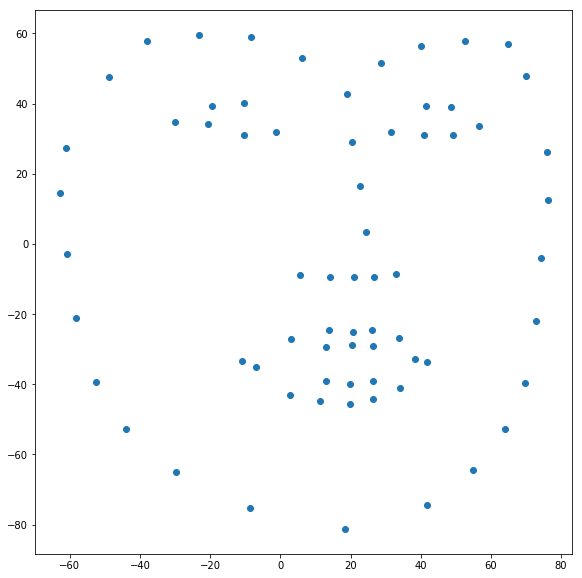

In [5]:
# Visualize facial landmark points on the 2D image plane.
landmark_index=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmark_index.append(int(line.split('\n')[0]))
G_landmark = np.ones((4,len(landmark_index)))
G_landmark[:3,:]= G[landmark_index,:].T
theta = np.pi/18.
T = np.array([[np.cos(theta),0, np.sin(theta),0],
              [0,1,0,0],[-np.sin(theta),0,np.cos(theta),0],
              [0,0,0,1]])
vl,vr,vb,vt = 0,1,0,1
V = np.array([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t,n,f = 0,1,0,1,1,100
P = np.array([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t-b),(t+b)/(t-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-n)],
              [0,0,-1,0]])
output = V @ P @ T @ G_landmark
fig = plt.figure(figsize=(15, 10))
plt.scatter(output[0,:],output[1,:])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/landmark_roty.png')

## Section 4: Latent Parameters Estimation

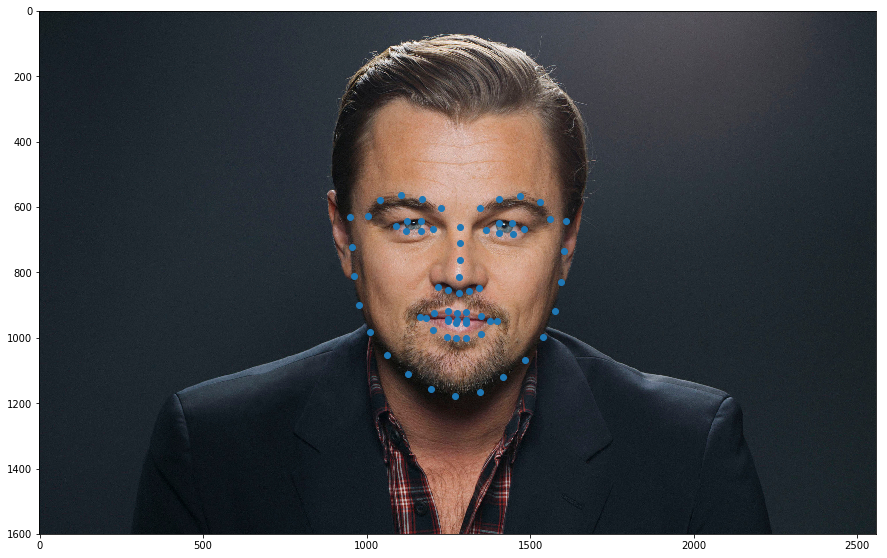

In [6]:
# Extract ground truth landmarks.
# For Leo.
face_image = mpimg.imread('leo.jpg')
# For doge.
# face_image = mpimg.imread('doge.png')
# face_image = (face_image[:, :, :3] * 256).astype(np.uint8)

face_landmarks_gt = detect_landmark(face_image)
H, W = face_image.shape[0], face_image.shape[1]

fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/face_landmarks_gt.png')

In [7]:
def get_transformation(omega,t):
    # Define Rotation matrix.
    Rx, Ry, Rz = torch.zeros(3, 3), torch.zeros(3, 3), torch.zeros(3, 3)
    Rx[0, 0] = 1.
    Rx[1, 1] = torch.cos(omega[0])
    Rx[1, 2] = -torch.sin(omega[0])
    Rx[2, 1] = torch.sin(omega[0])
    Rx[2, 2] = torch.cos(omega[0])

    Ry[0, 0] = torch.cos(omega[1])
    Ry[0, 2] = torch.sin(omega[1])
    Ry[1, 1] = 1.
    Ry[2, 0] = -torch.sin(omega[1])
    Ry[2, 2] = torch.cos(omega[1])
    
    Rz[0, 0] = torch.cos(omega[2])
    Rz[0, 1] = -torch.sin(omega[2])
    Rz[1, 0] = torch.sin(omega[2])
    Rz[1, 1] = torch.cos(omega[2])
    Rz[2, 2] = 1.
    
    R = Rx @ Ry @ Rz    
    T = torch.cat((torch.cat((R, t.view(-1, 1)), dim=1), torch.tensor([0., 0., 0., 1.]).view(1, -1)), dim=0)   
    return T

def get_projection(W, H, f, n, fovy):
    # Define camera projection matrices.
    V = torch.Tensor([[W/2, 0, 0, W/2],
                      [0, -H/2, 0, H/2],
                      [0, 0, 0.5, 0.5],
                      [0, 0, 0, 1]
                     ])

    aspect_ratio = W / H
    t = np.tan(fovy / 2) * n
    b = -t
    r = t * aspect_ratio
    l = -t * aspect_ratio
    P = torch.Tensor([[(2*n)/(r-l),0,(r+l)/(r-l),0],
                  [0,(2*n)/(t-b),(t+b)/(t-b),0],
                  [0,0,-(f+n)/(f-n),-(2*f*n)/(f-n)],
                  [0,0,-1,0]])
    return V, P

In [8]:
# Define Hyperparameters.
epochs = 500
lambda_alpha,lambda_delta= 1,1
fovy,near,far =0.5,300., 2000.
uni = 1

# Convert data to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id[landmark_index,:])
mu_exp_torch = torch.Tensor(mu_exp[landmark_index,:])
E_id_torch = torch.Tensor(E_id[landmark_index,:,:])
E_exp_torch = torch.Tensor(E_exp[landmark_index,:,:])
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)

# Initialize trainable variables.
gt_landmark = torch.Tensor(face_landmarks_gt).t()
alpha_torch = Variable(torch.FloatTensor(30).uniform_(-uni, uni), requires_grad=True)
delta_torch = Variable(torch.FloatTensor(20).uniform_(-uni, uni), requires_grad=True)
omega = Variable(torch.zeros(3), requires_grad=True)
t = Variable(torch.Tensor([0, 0, -400]), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([alpha_torch, delta_torch, omega, t], lr=0.1)

# Define camera projection matrices.
V, P = get_projection(W, H, far, near, fovy)
losses_land = []
losses_reg = []
losses_fit = []
for epoch in np.arange(epochs):
    opt.zero_grad()    
    G = mu_id_torch + E_id_torch @ (alpha_torch  * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta_torch * sigma_exp_torch)    
    G_landmark = torch.cat((torch.transpose(G,0,1), torch.ones(1, len(landmark_index))), 0)

    # Get Transformation
    T = get_transformation(omega,t)

    out = V @ P @ T @ G_landmark
    pred_landmark = out[:2, :] / out[3, :]

    L_landmark = (pred_landmark - gt_landmark).pow(2).sum(dim=0).sqrt().sum()
    L_regularizer = lambda_alpha * alpha_torch.pow(2).sum() + lambda_delta * delta_torch.pow(2).sum()
    L_fit = L_landmark + L_regularizer
    L_fit.backward(retain_graph=True)
    opt.step()    
    losses_land.append(L_landmark.item())
    losses_reg.append(L_regularizer)
    losses_fit.append(L_fit.item())
    if epoch % 10 ==0:
        print('Epoch: {}, L_landmark: {:.4f}, L_regularizer: {:.4f}, L_fit:{:.4f}'.format(epoch, L_landmark, L_regularizer,L_fit))    

Epoch: 0, L_landmark: 18386.0957, L_regularizer: 15.7587, L_fit:18401.8535
Epoch: 10, L_landmark: 14096.9746, L_regularizer: 47.7492, L_fit:14144.7236
Epoch: 20, L_landmark: 10098.8076, L_regularizer: 131.9874, L_fit:10230.7949
Epoch: 30, L_landmark: 7244.1909, L_regularizer: 242.6337, L_fit:7486.8247
Epoch: 40, L_landmark: 5195.9512, L_regularizer: 344.6488, L_fit:5540.6001
Epoch: 50, L_landmark: 3693.6985, L_regularizer: 411.8405, L_fit:4105.5391
Epoch: 60, L_landmark: 2728.4463, L_regularizer: 454.2971, L_fit:3182.7434
Epoch: 70, L_landmark: 2160.4204, L_regularizer: 464.8047, L_fit:2625.2251
Epoch: 80, L_landmark: 1578.9030, L_regularizer: 468.1360, L_fit:2047.0389
Epoch: 90, L_landmark: 1422.7048, L_regularizer: 455.9240, L_fit:1878.6289
Epoch: 100, L_landmark: 1136.9205, L_regularizer: 439.0476, L_fit:1575.9681
Epoch: 110, L_landmark: 1002.1425, L_regularizer: 429.6548, L_fit:1431.7974
Epoch: 120, L_landmark: 950.0721, L_regularizer: 416.3806, L_fit:1366.4526
Epoch: 130, L_landma

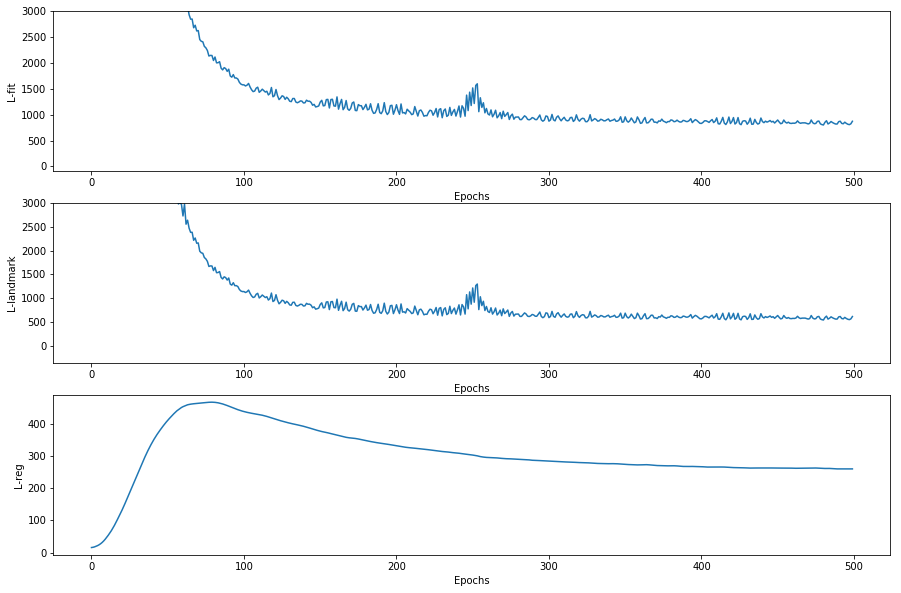

In [9]:
# Plot losses.
fig = plt.figure(figsize= (15, 10))
plt.subplot(3, 1, 1)
plt.plot(np.arange(epochs), losses_fit)
plt.xlabel('Epochs')
plt.ylabel('L-fit')
plt.ylim(top=3000)
plt.subplot(3, 1, 2)
plt.plot(np.arange(epochs), losses_land)
plt.xlabel('Epochs')
plt.ylabel('L-landmark')
plt.ylim(top=3000)
plt.subplot(3, 1, 3)
plt.plot(np.arange(epochs), losses_reg)
plt.xlabel('Epochs')
plt.ylabel('L-reg')
plt.show()
fig.savefig('results/losses_uniform_{}.png'.format(str(uni).replace('.', '_')))

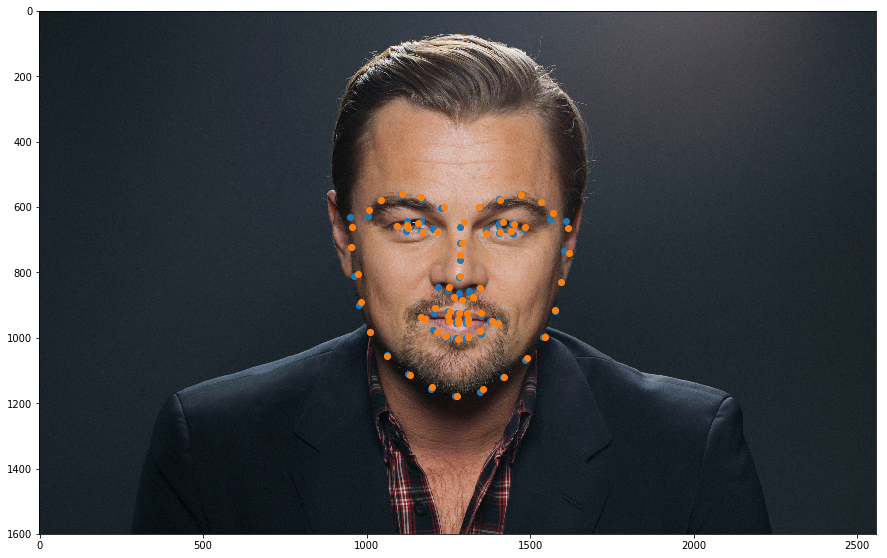

In [10]:
# Plot landmark matchings.
fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
[x,y]=pred_landmark.detach().numpy()[:2,:]
plt.scatter(x,y)
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/landmarks_matches_uniform_{}.png'.format(str(uni).replace('.', '_')))

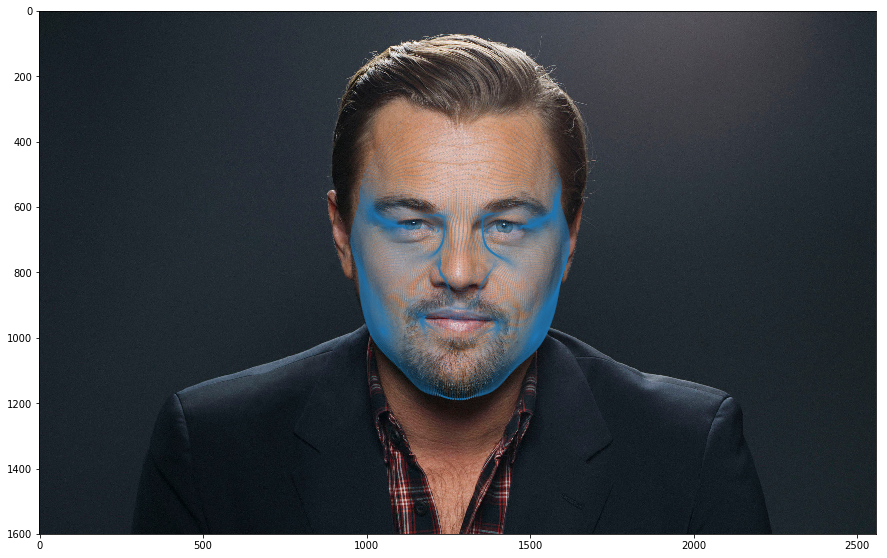

In [11]:
# Evaluatation
mu_id_eval = torch.Tensor(mu_id)
mu_exp_eval = torch.Tensor(mu_exp)
E_id_eval = torch.Tensor(E_id)
E_exp_eval = torch.Tensor(E_exp)
G = mu_id_eval + E_id_eval @ (alpha_torch * sigma_id_torch) + mu_exp_eval + E_exp_eval @ (delta_torch * sigma_exp_torch)  
G_homo = torch.cat((torch.transpose(G,0,1), torch.ones(1, G.size(0))), 0)
fit = V @ P @ T @ G_homo
fig = plt.figure(figsize=(15, 10))
plt.imshow(face_image)
ax=fig.add_subplot(111)
[x,y,z]=fit.detach().numpy()[:3, :] / fit.detach().numpy()[3, :]
ax.scatter(x,y,z,marker='.')
plt.show()
fig.savefig('results/point_cloud_fit_uniform_{}.png'.format(str(uni).replace('.', '_')))

## Section 5: Texturing

In [12]:
# Store latent parameters for avatar.
ava_alpha_torch = alpha_torch.detach()
ava_delta_torch = delta_torch.detach()
ava_omega = omega.detach()
ava_t = t.detach()

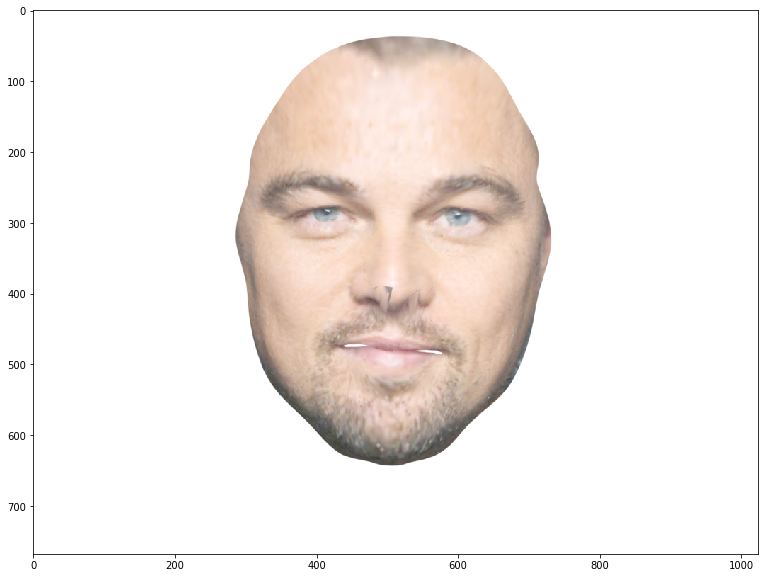

In [13]:
transformed = fit.detach().numpy()[:3, :] / fit.detach().numpy()[3, :]
# Binary interpolation.
interpolated = np.empty_like(transformed, dtype=np.uint8)
for p_i in np.arange(transformed.shape[1]):
    x = transformed[0, p_i]
    y = transformed[1, p_i]

    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))   
    y1 = int(np.ceil(y))
    y2 = int(np.floor(y))

    Q11 = face_image[y1, x1, :]
    Q12 = face_image[y2, x1, :]
    Q21 = face_image[y1, x1, :]
    Q22 = face_image[y2, x2, :]
    denom = ((x2 - x1) * (y2 - y1))
    if np.isclose(denom, 0.):
        interpolated[:, p_i] = np.array([128, 128, 128])
        continue
    for i_c in np.arange(3):                
        tmp = 1./denom * np.array([x2 - x, x - x1]) @ np.array([[Q11[i_c], Q12[i_c]], [Q21[i_c], Q22[i_c]]]) @ np.array([y2 - y, y - y1])        
        interpolated[i_c, p_i] = tmp
texture = np.float32(interpolated.T/255.)

# Adjust the 3D model for rendering.
a = 0.4 * np.expand_dims(transformed[0, :] - np.mean(transformed[0, :], axis=-1, keepdims=True), axis=0)
b = - 0.4 * np.expand_dims(transformed[1, :] - np.mean(transformed[1, :], axis=-1, keepdims=True), axis=0)
c = np.expand_dims(transformed[2, :], axis=0)
transformed_mesh = np.concatenate((a, b, c), axis=0).T

# Render image.
mesh = Mesh(transformed_mesh, texture , triangles)
filepath = 'results/texturing.png'
mesh_to_png(filepath, mesh)
fig = plt.figure(figsize=(15, 10))
image = mpimg.imread(filepath)
plt.imshow(image)
ava_texture = texture

## Section 6: Energy Optimization Using Multiple Frames

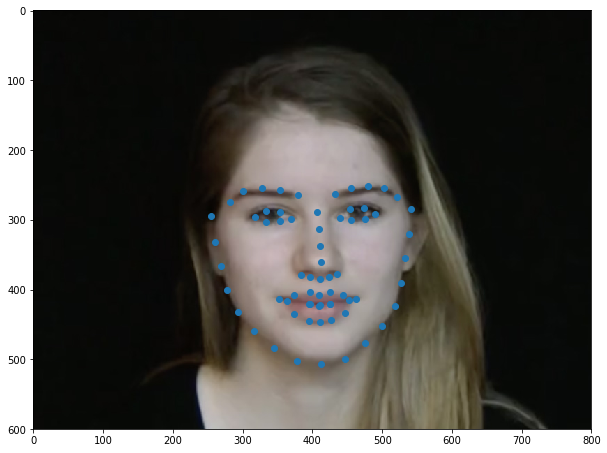

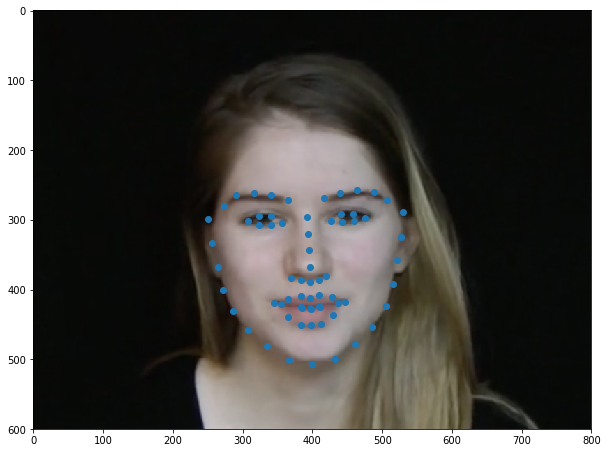

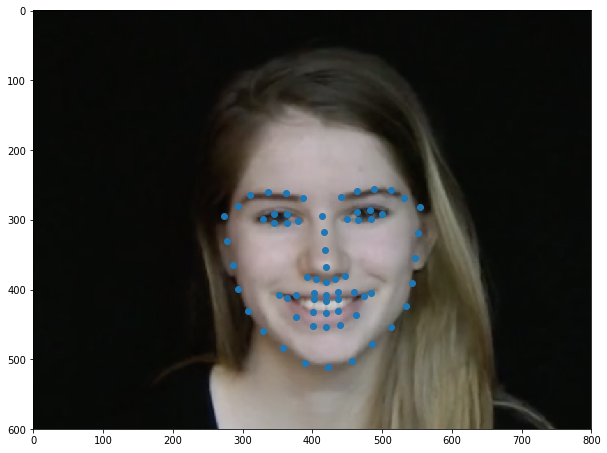

In [14]:
# Load multiple frames and extract ground truth landmarks.
face_images = []
face_landmarks = []
face_images.append(mpimg.imread('test1.jpg'))
face_images.append(mpimg.imread('test2.jpg'))
face_images.append(mpimg.imread('test3.jpg'))
M = len(face_images)
for i,face_image in enumerate(face_images):
    face_landmark = detect_landmark(face_image)
    H, W = face_image.shape[0], face_image.shape[1]
    fig = plt.figure(figsize = (10,10))
    plt.imshow(face_image)
    plt.scatter(face_landmark[:, 0], face_landmark[:, 1])
    plt.show()
    face_landmarks.append(torch.Tensor(face_landmark).t())
    fig.savefig('results/face_landmarks_gt_image{}.png'.format(i))

In [15]:
# Define Hyperparameters.
epochs = 500
lambda_alpha,lambda_delta= 1,1
fovy,near,far =0.5,300., 2000.
uni = 1
# Convert data to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id[landmark_index,:])
mu_exp_torch = torch.Tensor(mu_exp[landmark_index,:])
E_id_torch = torch.Tensor(E_id[landmark_index,:,:])
E_exp_torch = torch.Tensor(E_exp[landmark_index,:,:])
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)

# Initialize trainable variables.

alpha_torch = Variable(torch.FloatTensor(30).uniform_(-uni, uni), requires_grad=True)
delta_torch = Variable(torch.FloatTensor(M, 20).uniform_(-uni, uni), requires_grad=True)
omega = Variable(torch.zeros(M,3), requires_grad=True)
t = Variable(torch.Tensor(np.tile([0,0,-400],[M,1])), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([alpha_torch, delta_torch, omega, t], lr=0.1)

# Define camera projection matrices.
V, P = get_projection(W, H, far, near, fovy)
avg_losses_land = []
avg_losses_reg = []
avg_losses_fit = []
for epoch in np.arange(epochs):
    opt.zero_grad()    
    L_landmark = 0
    L_regularizer = 0
    pred_landmarks=[]
    for i in range(M):
        G = mu_id_torch + E_id_torch @ (alpha_torch  * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta_torch[i, :] * sigma_exp_torch)    
        G_landmark = torch.cat((torch.transpose(G,0,1), torch.ones(1, len(landmark_index))), 0)            
        T = get_transformation(omega[i,:],t[i,:])
        out = V @ P @ T @ G_landmark
        pred_landmark = out[:2, :] / out[3, :]
        pred_landmarks.append(pred_landmark)
        L_landmark = L_landmark + (pred_landmark - face_landmarks[i]).pow(2).sum(dim=0).sqrt().sum()
        L_regularizer = L_regularizer + lambda_alpha * alpha_torch.pow(2).sum() + lambda_delta * delta_torch[i, :].pow(2).sum()                
    L_fit = L_landmark + L_regularizer
    L_fit.backward(retain_graph=True)
    opt.step()    
    avg_losses_land.append(L_landmark.item() / M)
    avg_losses_reg.append(L_regularizer.item() / M)
    avg_losses_fit.append(L_fit.item() / M)
    if epoch % 10 ==0:
        print('Epoch: {}, Average L_landmark: {:.4f}, Average L_regularizer: {:.4f}, Average L_fit:{:.4f}'.format(epoch, L_landmark / M, L_regularizer / M, L_fit / M))

Epoch: 0, Average L_landmark: 6017.1641, Average L_regularizer: 17.6735, Average L_fit:6034.8374
Epoch: 10, Average L_landmark: 3997.4785, Average L_regularizer: 48.8554, Average L_fit:4046.3340
Epoch: 20, Average L_landmark: 2628.4031, Average L_regularizer: 128.0850, Average L_fit:2756.4880
Epoch: 30, Average L_landmark: 1831.8506, Average L_regularizer: 188.0594, Average L_fit:2019.9100
Epoch: 40, Average L_landmark: 1188.4614, Average L_regularizer: 226.6508, Average L_fit:1415.1123
Epoch: 50, Average L_landmark: 738.4426, Average L_regularizer: 271.9429, Average L_fit:1010.3855
Epoch: 60, Average L_landmark: 490.5168, Average L_regularizer: 285.6589, Average L_fit:776.1758
Epoch: 70, Average L_landmark: 402.0173, Average L_regularizer: 272.7693, Average L_fit:674.7867
Epoch: 80, Average L_landmark: 360.3227, Average L_regularizer: 243.4551, Average L_fit:603.7778
Epoch: 90, Average L_landmark: 316.1540, Average L_regularizer: 225.9101, Average L_fit:542.0640
Epoch: 100, Average L_

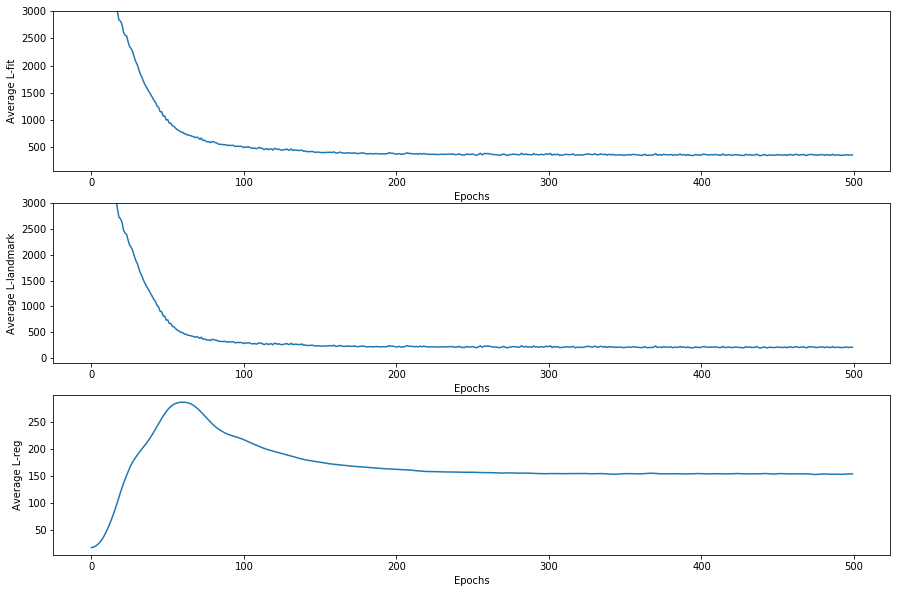

In [16]:
# Plot losses.
fig = plt.figure(figsize= (15, 10))
plt.subplot(3, 1, 1)
plt.plot(np.arange(epochs), avg_losses_fit)
plt.ylim(top=3000)
plt.xlabel('Epochs')
plt.ylabel('Average L-fit')
plt.subplot(3, 1, 2)
plt.plot(np.arange(epochs), avg_losses_land)
plt.ylim(top=3000)
plt.xlabel('Epochs')
plt.ylabel('Average L-landmark')
plt.subplot(3, 1, 3)
plt.plot(np.arange(epochs), avg_losses_reg)
plt.xlabel('Epochs')
plt.ylabel('Average L-reg')
plt.show()
fig.savefig('results/losses.png')

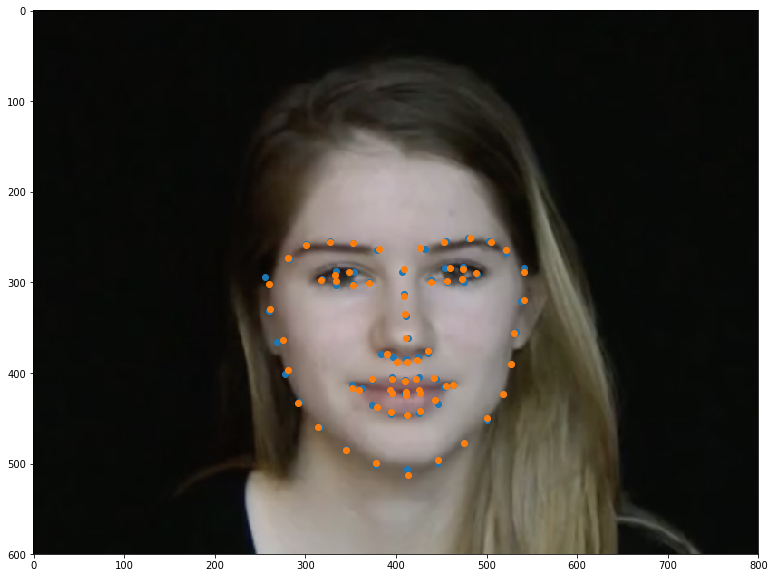

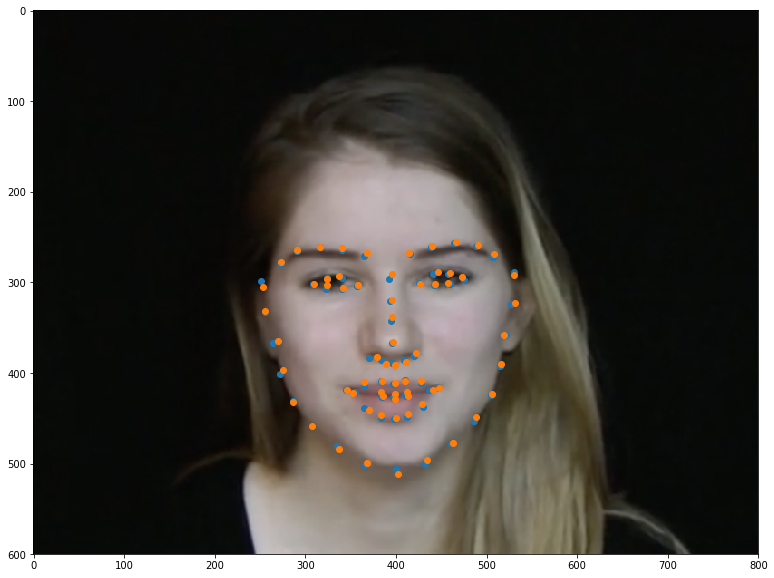

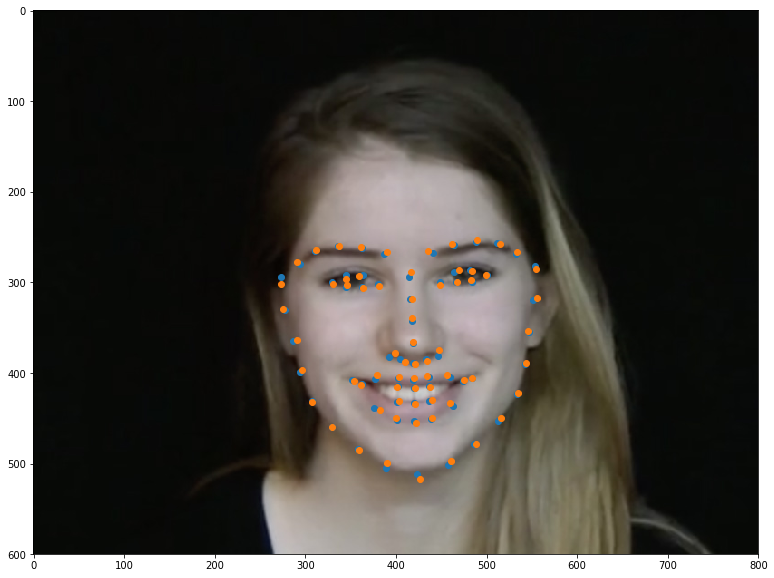

In [17]:
# Visualize landmark matchings.
for i,face_image in enumerate(face_images):
    fig = plt.figure(figsize = (15,10))
    plt.imshow(face_image)
    face_landmarks_gt=face_landmarks[i].numpy().T
    plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
    [x,y]=pred_landmarks[i].detach().numpy()[:2,:]
    plt.scatter(x,y)
    plt.axes().set_aspect('equal')
    plt.show()
    fig.savefig('results/landmarks_matches_image_{}.png'.format(i))

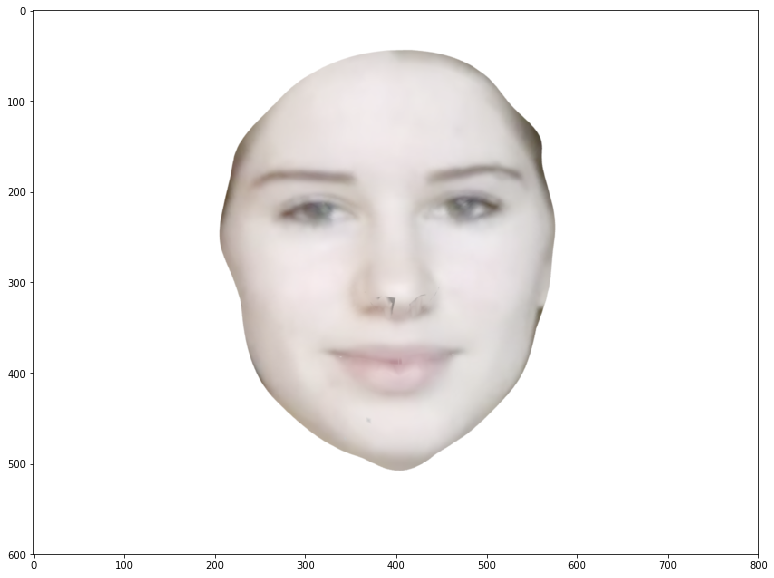

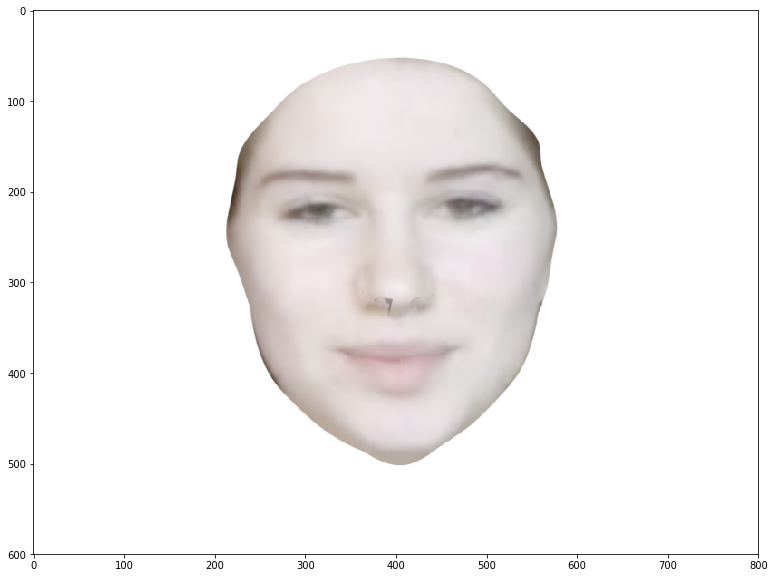

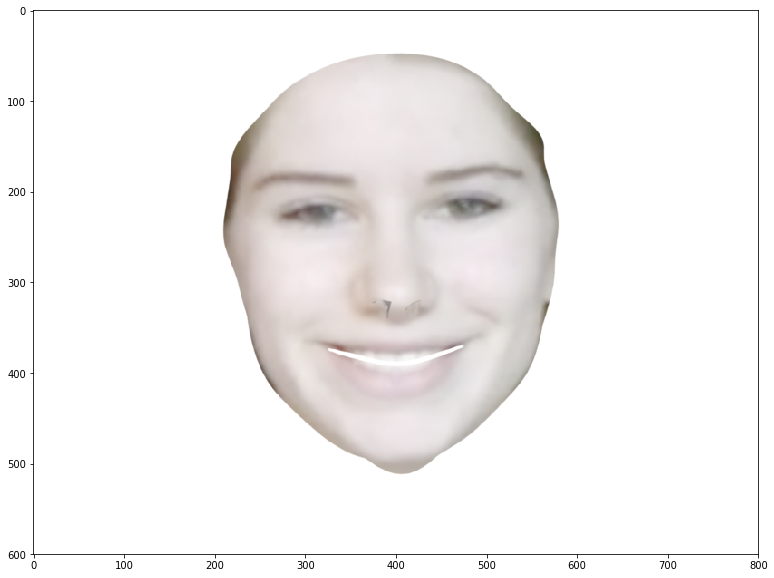

In [18]:
# Visualize the transfered, textured mesh for each frame.
mu_id_eval = torch.Tensor(mu_id)
mu_exp_eval = torch.Tensor(mu_exp)
E_id_eval = torch.Tensor(E_id)
E_exp_eval = torch.Tensor(E_exp)
for i,face_image in enumerate(face_images):
    G = mu_id_eval + E_id_eval @ (alpha_torch * sigma_id_torch) + mu_exp_eval + E_exp_eval @ (delta_torch[i, :] * sigma_exp_torch)  
    G_homo = torch.cat((torch.transpose(G,0,1), torch.ones(1, G.size(0))), 0)    
    T = get_transformation(omega[i,:],t[i,:])
    fit = V @ P @ T @ G_homo    
    transformed = fit.detach().numpy()[:3, :] / fit.detach().numpy()[3, :]
    
    interpolated = np.empty_like(transformed, dtype=np.uint8)
    for p_i in np.arange(transformed.shape[1]):
        x = transformed[0, p_i]
        y = transformed[1, p_i]

        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))   
        y1 = int(np.ceil(y))
        y2 = int(np.floor(y))

        Q11 = face_image[y1, x1, :]
        Q12 = face_image[y2, x1, :]
        Q21 = face_image[y1, x1, :]
        Q22 = face_image[y2, x2, :]
        denom = ((x2 - x1) * (y2 - y1))
        if np.isclose(denom, 0.):
            interpolated[:, p_i] = np.array([128, 128, 128])
            continue
        for i_c in np.arange(3):                
            tmp = 1./denom * np.array([x2 - x, x - x1]) @ np.array([[Q11[i_c], Q12[i_c]], [Q21[i_c], Q22[i_c]]]) @ np.array([y2 - y, y - y1])        
            interpolated[i_c, p_i] = tmp
    texture = np.float32(interpolated.T/255.)    

    a = np.expand_dims(transformed[0, :] - np.mean(transformed[0, :], axis=-1, keepdims=True), axis=0)
    b = - np.expand_dims(transformed[1, :] - np.mean(transformed[1, :], axis=-1, keepdims=True), axis=0)
    c = np.expand_dims(transformed[2, :], axis=0)
    transformed_mesh = np.concatenate((a, b, c), axis=0).T
    
    mesh = Mesh(transformed_mesh, texture , triangles)
    filepath = 'results/texturing_image_{}.png'.format(i)
    mesh_to_png(filepath, mesh, width = W, height = H) 
    fig = plt.figure(figsize=(15, 10))    
    image = mpimg.imread(filepath)
    plt.imshow(image)
    

## Section 7: Expression Manipulation

In [19]:
# Load sequence of images from the source video.
J = 50
M = 10
face_images = []
face_landmarks = []
for i in np.arange(1, J + 1):
    face_image = mpimg.imread('video/frames/fake_smile {:02d}.jpg'.format(i))
    face_images.append(face_image)
    face_landmark = detect_landmark(face_image)
    face_landmarks.append(torch.Tensor(face_landmark).t())

H, W = face_images[0].shape[0], face_images[0].shape[1]

# Estimate source identity alpha using M frames.

# Define Hyperparameters.
epochs = 500
lambda_alpha,lambda_delta= 1,1
fovy,near,far =0.5,300., 2000.
uni = 1
# Convert data to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id[landmark_index,:])
mu_exp_torch = torch.Tensor(mu_exp[landmark_index,:])
E_id_torch = torch.Tensor(E_id[landmark_index,:,:])
E_exp_torch = torch.Tensor(E_exp[landmark_index,:,:])
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)

# Initialize trainable variables.

alpha_torch = Variable(torch.FloatTensor(30).uniform_(-uni, uni), requires_grad=True)
delta_torch = Variable(torch.FloatTensor(M, 20).uniform_(-uni, uni), requires_grad=True)
omega = Variable(torch.zeros(M,3), requires_grad=True)
t = Variable(torch.Tensor(np.tile([0,0,-400],[M,1])), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([alpha_torch, delta_torch, omega, t], lr=0.1)

# Define camera projection matrices.
V, P = get_projection(W, H, far, near, fovy)
avg_losses_land = []
avg_losses_reg = []
avg_losses_fit = []
for epoch in np.arange(epochs):
    opt.zero_grad()    
    L_landmark = 0
    L_regularizer = 0
    pred_landmarks=[]
    for i in range(M):
        G = mu_id_torch + E_id_torch @ (alpha_torch  * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta_torch[i, :] * sigma_exp_torch)    
        G_landmark = torch.cat((torch.transpose(G,0,1), torch.ones(1, len(landmark_index))), 0)            
        T = get_transformation(omega[i,:],t[i,:])
        out = V @ P @ T @ G_landmark
        pred_landmark = out[:2, :] / out[3, :]
        pred_landmarks.append(pred_landmark)
        L_landmark = L_landmark + (pred_landmark - face_landmarks[i]).pow(2).sum(dim=0).sqrt().sum()
        L_regularizer = L_regularizer + lambda_alpha * alpha_torch.pow(2).sum() + lambda_delta * delta_torch[i, :].pow(2).sum()                
    L_fit = L_landmark + L_regularizer
    L_fit.backward(retain_graph=True)
    opt.step()    
    avg_losses_land.append(L_landmark.item() / M)
    avg_losses_reg.append(L_regularizer.item() / M)
    avg_losses_fit.append(L_fit.item() / M)
    if epoch % 10 ==0:
        print('Epoch: {}, Average L_landmark: {:.4f}, Average L_regularizer: {:.4f}, Average L_fit:{:.4f}'.format(epoch, L_landmark / M, L_regularizer / M, L_fit / M))

Epoch: 0, Average L_landmark: 8112.6001, Average L_regularizer: 16.7200, Average L_fit:8129.3203
Epoch: 10, Average L_landmark: 6288.9463, Average L_regularizer: 47.0870, Average L_fit:6336.0337
Epoch: 20, Average L_landmark: 4842.1196, Average L_regularizer: 133.6117, Average L_fit:4975.7314
Epoch: 30, Average L_landmark: 3710.9087, Average L_regularizer: 249.6507, Average L_fit:3960.5593
Epoch: 40, Average L_landmark: 2885.4026, Average L_regularizer: 356.6643, Average L_fit:3242.0669
Epoch: 50, Average L_landmark: 2261.6282, Average L_regularizer: 420.1047, Average L_fit:2681.7329
Epoch: 60, Average L_landmark: 1789.7656, Average L_regularizer: 467.7965, Average L_fit:2257.5620
Epoch: 70, Average L_landmark: 1391.7625, Average L_regularizer: 490.7029, Average L_fit:1882.4655
Epoch: 80, Average L_landmark: 1101.1764, Average L_regularizer: 502.7148, Average L_fit:1603.8911
Epoch: 90, Average L_landmark: 911.1581, Average L_regularizer: 500.8538, Average L_fit:1412.0120
Epoch: 100, Av

In [20]:
# Estimate rest of the parameters using J frames (all).
alpha_torch = alpha_torch.detach()
delta_torch = Variable(torch.FloatTensor(J, 20).uniform_(-uni, uni), requires_grad=True)
omega = Variable(torch.zeros(J,3), requires_grad=True)
t = Variable(torch.Tensor(np.tile([0,0,-400],[J,1])), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([delta_torch, omega, t], lr=0.1)
# Define camera projection matrices.
V, P = get_projection(W, H, far, near, fovy)
avg_losses_land = []
avg_losses_reg = []
avg_losses_fit = []
for epoch in np.arange(epochs):
    opt.zero_grad()    
    L_landmark = 0
    L_regularizer = 0
    pred_landmarks=[]
    for i in range(J):
        G = mu_id_torch + E_id_torch @ (alpha_torch  * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta_torch[i, :] * sigma_exp_torch)    
        G_landmark = torch.cat((torch.transpose(G,0,1), torch.ones(1, len(landmark_index))), 0)            
        T = get_transformation(omega[i,:],t[i,:])
        out = V @ P @ T @ G_landmark
        pred_landmark = out[:2, :] / out[3, :]
        pred_landmarks.append(pred_landmark)
        L_landmark = L_landmark + (pred_landmark - face_landmarks[i]).pow(2).sum(dim=0).sqrt().sum()
        L_regularizer = L_regularizer + lambda_alpha * alpha_torch.pow(2).sum() + lambda_delta * delta_torch[i, :].pow(2).sum()                
    L_fit = L_landmark + L_regularizer
    L_fit.backward(retain_graph=True)
    opt.step()    
    avg_losses_land.append(L_landmark.item() / J)
    avg_losses_reg.append(L_regularizer.item() / J)
    avg_losses_fit.append(L_fit.item() / J)
    if epoch % 10 ==0:
        print('Epoch: {}, Average L_landmark: {:.4f}, Average L_regularizer: {:.4f}, Average L_fit:{:.4f}'.format(epoch, L_landmark / J, L_regularizer / J, L_fit / J))

Epoch: 0, Average L_landmark: 2131.7224, Average L_regularizer: 246.8998, Average L_fit:2378.6223
Epoch: 10, Average L_landmark: 845.6206, Average L_regularizer: 252.1379, Average L_fit:1097.7585
Epoch: 20, Average L_landmark: 598.0530, Average L_regularizer: 262.2944, Average L_fit:860.3474
Epoch: 30, Average L_landmark: 453.8687, Average L_regularizer: 265.9954, Average L_fit:719.8641
Epoch: 40, Average L_landmark: 394.7207, Average L_regularizer: 269.5202, Average L_fit:664.2408
Epoch: 50, Average L_landmark: 355.4539, Average L_regularizer: 272.3646, Average L_fit:627.8185
Epoch: 60, Average L_landmark: 332.1487, Average L_regularizer: 276.9460, Average L_fit:609.0948
Epoch: 70, Average L_landmark: 318.4469, Average L_regularizer: 281.1622, Average L_fit:599.6091
Epoch: 80, Average L_landmark: 308.3734, Average L_regularizer: 283.9625, Average L_fit:592.3359
Epoch: 90, Average L_landmark: 302.1297, Average L_regularizer: 285.7186, Average L_fit:587.8483
Epoch: 100, Average L_landma

/Users/robbie/anaconda3/envs/cv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


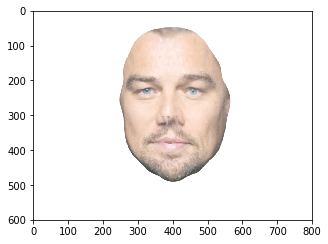

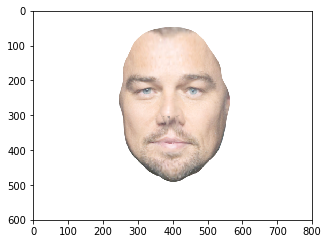

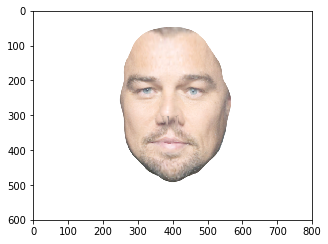

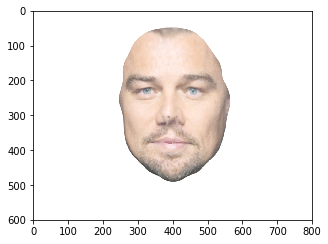

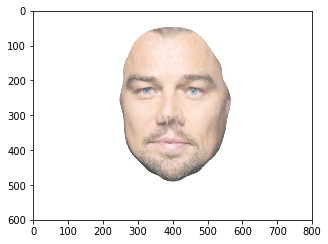

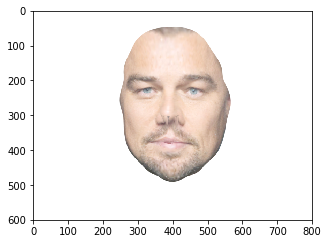

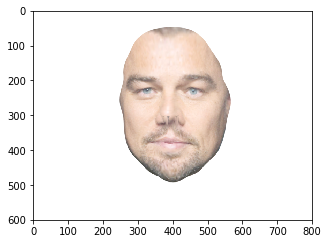

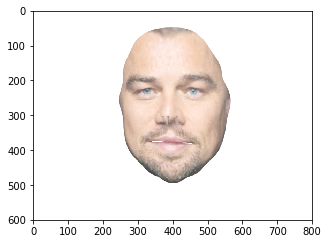

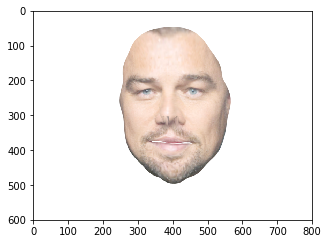

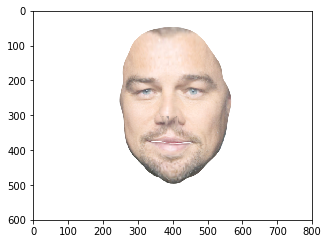

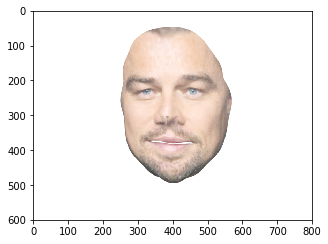

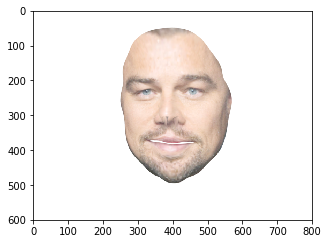

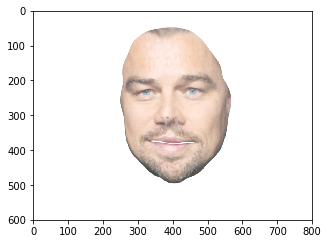

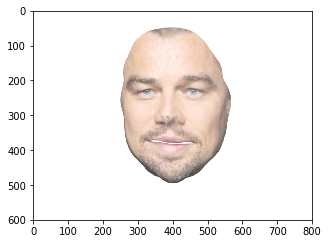

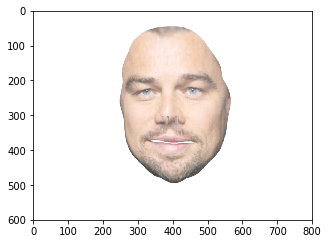

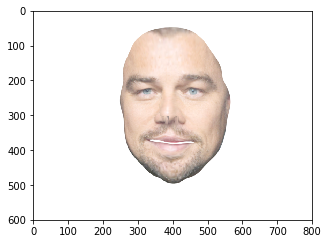

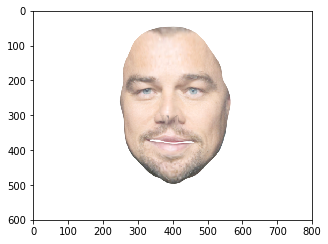

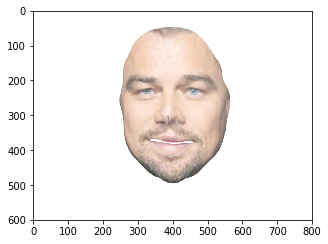

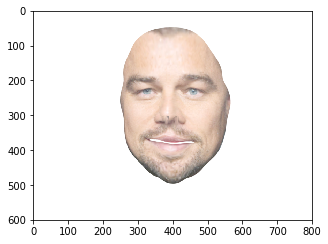

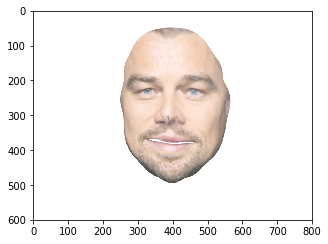

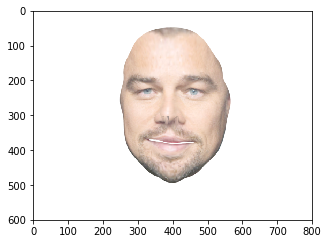

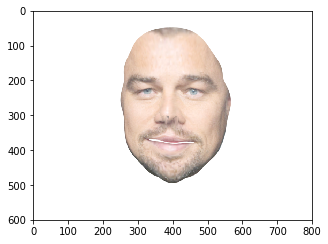

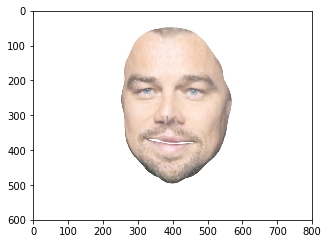

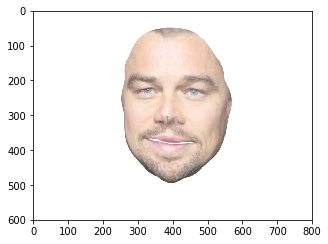

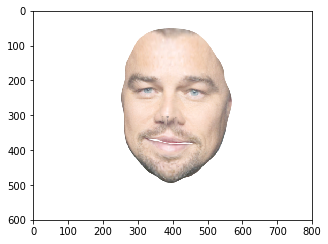

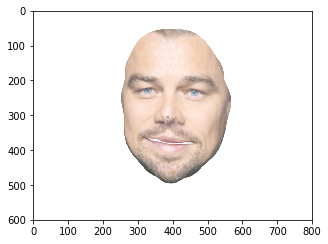

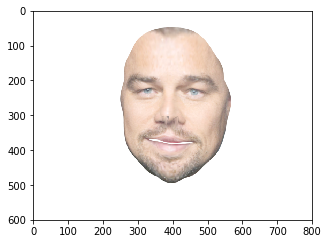

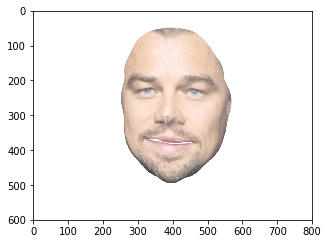

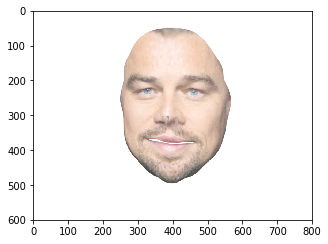

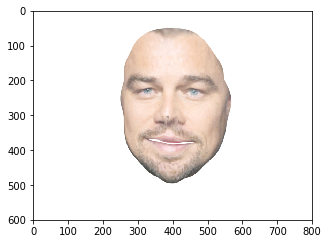

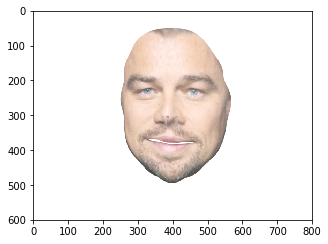

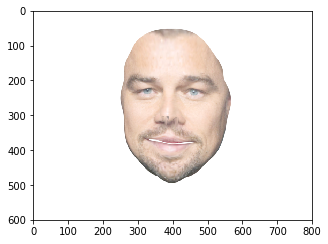

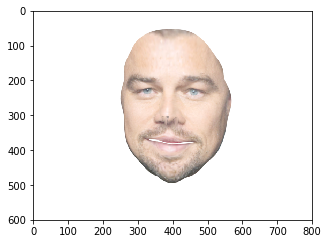

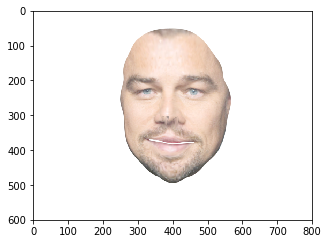

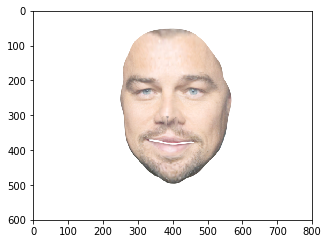

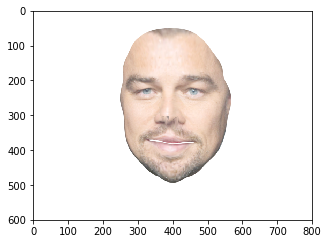

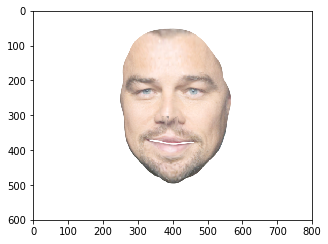

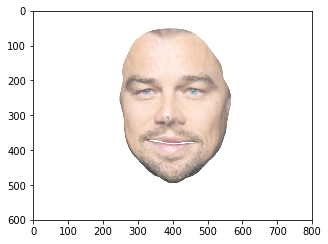

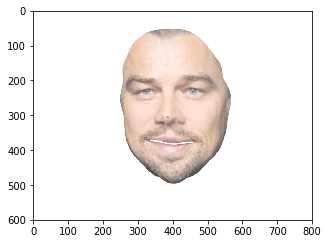

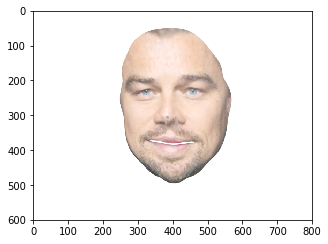

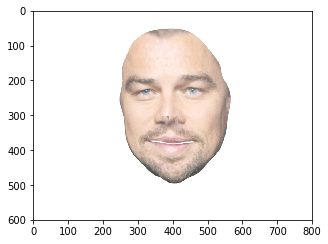

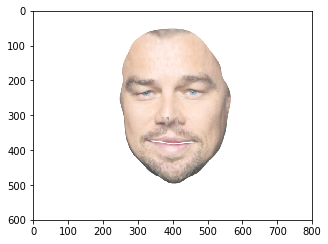

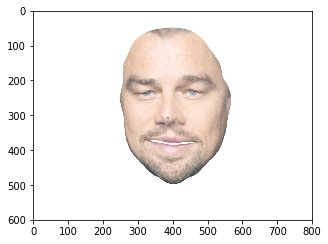

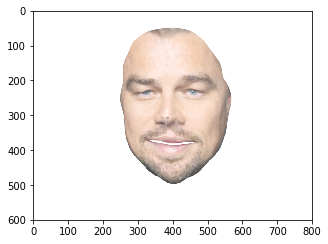

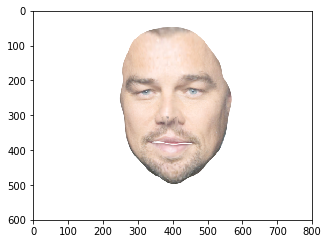

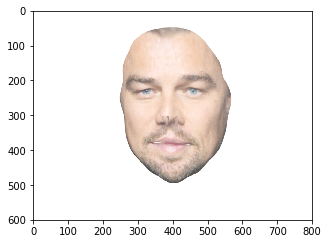

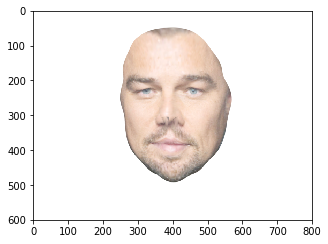

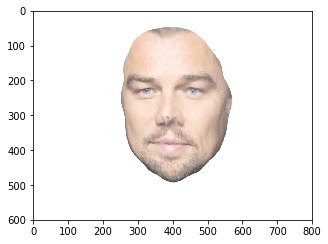

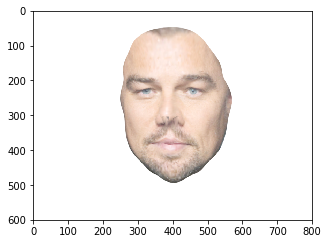

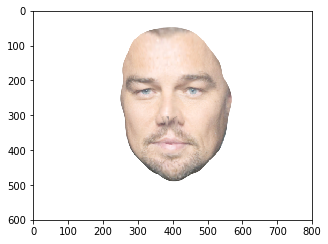

In [21]:
# Synthesize expression manipulated avatar corresponding to each frame in the source video.
ava_face_image = mpimg.imread('leo.jpg')
os.makedirs('results/video',exist_ok=True)
mu_id_eval = torch.Tensor(mu_id)
mu_exp_eval = torch.Tensor(mu_exp)
E_id_eval = torch.Tensor(E_id)
E_exp_eval = torch.Tensor(E_exp)
for i,face_image in enumerate(face_images):
    G = mu_id_eval + E_id_eval @ (ava_alpha_torch * sigma_id_torch) + mu_exp_eval + E_exp_eval @ (delta_torch[i, :] * sigma_exp_torch)  
    G_homo = torch.cat((torch.transpose(G,0,1), torch.ones(1, G.size(0))), 0)    
    T = get_transformation(omega[i,:],t[i,:])
    fit = V @ P @ T @ G_homo    
    transformed = fit.detach().numpy()[:3, :] / fit.detach().numpy()[3, :]

    a = np.expand_dims(transformed[0, :] - np.mean(transformed[0, :], axis=-1, keepdims=True), axis=0)
    b = - np.expand_dims(transformed[1, :] - np.mean(transformed[1, :], axis=-1, keepdims=True), axis=0)
    c = np.expand_dims(transformed[2, :], axis=0)
    transformed_mesh = np.concatenate((a, b, c), axis=0).T
    
    mesh = Mesh(transformed_mesh, ava_texture , triangles)
    filepath = 'results/video/leo_fake_smile_{}.png'.format(i)
    mesh_to_png(filepath, mesh, width = W, height = H) 
    fig = plt.figure(figsize=(5,5))    
    image = mpimg.imread(filepath)
    plt.imshow(image)
    

In [22]:
os.system('ffmpeg -r 50 -i results/video/leo_fake_smile_%d.png -c:v libx264 -vf fps=50 -pix_fmt yuv420p out.mp4')

256